### This notebook contains 2 parts. Part 1 for training model and part 2 for generating prediction data set from web inputs.

# Part 1. Processed Training Data Features Explained

N_violation: number of violations, target value to predict.

Street: instead of readible names, each street is defined by 'County code'+'5digit street code'. 

Hour and AP: hour of the day.

weekday:  day of the week, from 0 to 6 ( Monday to Sunday).

xd before, on day, yd after: whether today is x day before, on or y day after a national holiday. 

location_x, location_y: longitude and latitude of street's center.

In [217]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import dill
import warnings
warnings.filterwarnings('ignore')

In [8]:
df_train =  pd.read_csv('../data/training.csv')
df_train.head()

,Issue Date,Street,Hour,AP,N_violation,weekday,3d before,2d before,1d before,on day,1d after,2d after,3d after,location_x,location_y,Month
0,2015-01-01,110010,2,P,2,3,False,False,False,True,False,False,False,40.757884,-73.963205,1
1,2015-01-01,110010,11,A,2,3,False,False,False,True,False,False,False,40.757884,-73.963205,1
2,2015-01-01,110010,12,P,2,3,False,False,False,True,False,False,False,40.757884,-73.963205,1
3,2015-01-02,110010,1,P,6,4,False,False,False,False,True,False,False,40.757884,-73.963205,1
4,2015-01-02,110010,2,P,12,4,False,False,False,False,True,False,False,40.757884,-73.963205,1


In [158]:

columns = df_train.columns
columns = columns.drop(['Hour','AP'])
columns_g = columns.drop(['N_violation'])


#morning
df_tmp = df_train
df_tmp=df_tmp[(df_tmp.AP=='A')&(df_tmp.Hour<11)][columns]
df_tmp = df_tmp.groupby(list(columns_g))['N_violation'].sum().reset_index()
df_tmp['time'] = ['Morning']*len(df_tmp)
df_morning = df_tmp

#noon
df_tmp = df_train
df_tmp=df_tmp[((df_tmp.AP=='P')&(df_tmp.Hour<=2))|((df_tmp.AP=='A')&(df_tmp.Hour>=11))][columns]
df_tmp = df_tmp.groupby(list(columns_g))['N_violation'].sum().reset_index()
df_tmp['time'] = ['Noon']*len(df_tmp)
df_noon = df_tmp

#Afternoon
df_tmp = df_train
df_tmp=df_tmp[(df_tmp.AP=='P')&(df_tmp.Hour<=6)&(df_tmp.Hour>2)][columns]
df_tmp = df_tmp.groupby(list(columns_g))['N_violation'].sum().reset_index()
df_tmp['time'] = ['Afternoon']*len(df_tmp)
df_afternoon = df_tmp

#Afternoon
df_tmp = df_train
df_tmp=df_tmp[(df_tmp.AP=='P')&(df_tmp.Hour>6)][columns]
df_tmp = df_tmp.groupby(list(columns_g))['N_violation'].sum().reset_index()
df_tmp['time'] = ['Evening']*len(df_tmp)
df_evening = df_tmp


df_all = df_morning.append(df_noon).append(df_afternoon).append(df_evening)
df_all = df_all.sort_values(['Street','Issue Date'])
# get overall violation
df_overall = df_all[['Street','N_violation']].groupby(['Street'])['N_violation'].sum().reset_index()
dict_overall = dict(zip(df_overall['Street'],df_overall['N_violation']))
dill.dump(dict_overall,open('../data/dict_overall.pkd','wb'))

df_all['Overall'] = df_all['Street'].map(lambda x: dict_overall[x] if x in dict_overall else 0)
df_all['N_violation'] =df_all['N_violation']/df_all['Overall'] 
df_all.head()

,Issue Date,Street,weekday,3d before,2d before,1d before,on day,1d after,2d after,3d after,location_x,location_y,Month,N_violation,time,Overall
23,2014-06-10,110010,1,False,False,False,False,False,False,False,40.757884,-73.963205,6,0.000061,Morning,16448
13,2014-06-11,110010,2,False,False,False,False,False,False,False,40.757884,-73.963205,6,0.000061,Noon,16448
62,2014-06-13,110010,4,False,False,False,False,False,False,False,40.757884,-73.963205,6,0.000061,Noon,16448
61,2014-06-14,110010,5,False,False,False,False,False,False,False,40.757884,-73.963205,6,0.000061,Afternoon,16448
136,2014-06-14,110010,5,False,False,False,False,False,False,False,40.757884,-73.963205,6,0.000061,Evening,16448


### Model

Tree regressor model (lighgbm) is picked for training. In these features, 'Street', 'time' and 'Month' are set to be categorical features, as number has no meaning in this case. After several trials, parameters of tree is chosen in the following way. Early stop is employed to make best prediction on test data. 

In [166]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
df =df_all

train_label = [ 'weekday','3d before', '2d before', '1d before', 'on day', '1d after', '2d after','3d after',\
               'location_x', 'location_y','Month','time']
target = 'N_violation'

categorical_feats=['time','Month']
for c in categorical_feats:
    df[c] = df[c].astype('category')
    
test_size=0.25
train_data,test_data = train_test_split(df, test_size=test_size, random_state=0)# for validation

y_train = train_data[target].values
X_train = train_data[train_label]
y_test = test_data[target].values
X_test = test_data[train_label]


lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test)


# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'mse',
    'metric': {'mse'},
    'num_leaves':32,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 0.5,
    'bagging_freq': 1,
    'verbose': 1,
    'min_data_in_leaf':1,
    'is_training_metric': True,
    #'max_bin':2,
    'min_data_in_bin':10,
    
}

print('Starting training...')
# train
Nround  =2000
evals_result = {}  
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=Nround,
                valid_sets=[lgb_train, lgb_eval],
                early_stopping_rounds=100,
                evals_result=evals_result,
                verbose_eval=50)
gbm.save_model('lgbm_fit.txt')

Starting training...
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 549
[LightGBM] [Info] Number of data points in the train set: 580167, number of used features: 12


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.008857
Training until validation scores don't improve for 100 rounds
[50]	training's l2: 0.00162289	valid_1's l2: 0.00167681
[100]	training's l2: 0.00149237	valid_1's l2: 0.00155941
[150]	training's l2: 0.00142584	valid_1's l2: 0.00150478
[200]	training's l2: 0.00138689	valid_1's l2: 0.00147575
[250]	training's l2: 0.00136057	valid_1's l2: 0.00145924
[300]	training's l2: 0.00134091	valid_1's l2: 0.0014493
[350]	training's l2: 0.00132393	valid_1's l2: 0.00144245
[400]	training's l2: 0.00130981	valid_1's l2: 0.00143886
[450]	training's l2: 0.0012964	valid_1's l2: 0.00143437
[500]	training's l2: 0.00128416	valid_1's l2: 0.00143079
[550]	training's l2: 0.00127321	valid_1's l2: 0.00142811
[600]	training's l2: 0.00126274	valid_1's l2: 0.00142561
[650]	training's l2: 0.00125309	valid_1's l2: 0.00142306
[700]	training's l2: 0.00124429	valid_1's l2: 0.00142148
[750]	trai

### Learning Curve

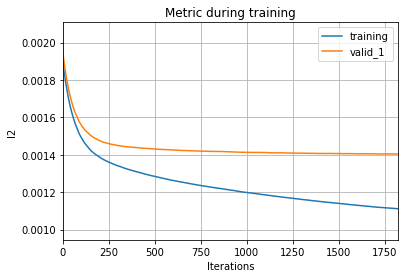

In [168]:
lgb.plot_metric(evals_result)

### Feature Importance

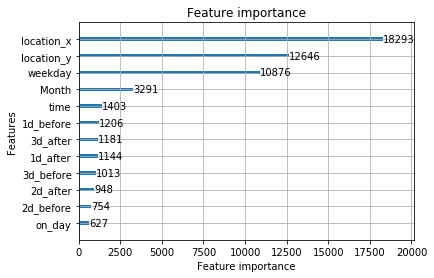

In [169]:
lgb.plot_importance(gbm)

# Part 2. Predict from web input

In the website, user has three options

a) location, the name of a street.

b) time of the day (morning, noon, afternoon,evening)

c) date up to next 7 days

For example:

In [210]:
Street_str = 'Times Square'
User_time = 'Noon'
num_date = 3 # 3 days from today, the option look like '11-15-2020' in the web 

### Generate dataframe for prediction

a) pick nearby streets for prediction

b) add month and weekday features



In [138]:
# find nearby streets
import dill
from geopy import Nominatim
df_street = dill.load(open('../data/df_street.pkd', 'rb'))
geolocator = Nominatim(user_agent="lz-application")
def nearby_locations(Street_str,df_street,size =0.03):
    location = geolocator.geocode(Street_str+' NYC')
    if not location:
        return []
    else:
        #df_street['distance'] = np.sqrt((df_street.location_x-location.latitude)**2+(df_street.location_y-location.longitude)**2)
        df_street=df_street[(df_street.location_x<(location.latitude+size))& (df_street.location_x>(location.latitude-size))\
                           &(df_street.location_y<(location.longitude+size))&(df_street.location_y>(location.longitude-size))]
        return df_street, location
street_nearby,location = nearby_locations(Street_str,df_street)

In [139]:
df_street.head(2)

,location_x,location_y,street
0,40.650043,-74.010814,305280
1,40.738908,-73.809556,447390


In [9]:
street_nearby.head(2)

,location_x,location_y,street
7,40.747630,-73.979730,100059
13,40.741881,-74.001638,134110


In [140]:
# destination of user
location

Location(Times Square, West 45th Street, Times Square, Manhattan Community Board 5, Times Square, New York County, New York, 10036, United States of America, (40.757280550000004, -73.98585503545917, 0.0))

### Date Feature

Get desired date first

In [141]:
from datetime import date,timedelta
today=date.today()
User_day=today+ timedelta(days=num_date)
User_day

datetime.date(2020, 11, 16)

get day of week and month

In [142]:
week_day = User_day.weekday()
week_day

0

In [143]:
month = User_day.month
month

11

Find information on holiday

In [144]:
def Find_holiday_value(User_day):
    Holidays = ['11/26/2020','12/25/2020','01/01/2021','01/18/2021','02/15/2021',\
               '04/19/2021','05/31/2021','07/05/2021','09/06/2021','10/11/2021']
    
    check_holiday={}
    for i in range(-3,4):
        if i<0:
            column_name = str(-i)+'d before'
        elif i==0:
            column_name = 'on day'
        else:
            column_name = str(i)+'d after'

        holi_tmp=pd.DatetimeIndex(Holidays).shift(i, freq='D')
        check_holiday[column_name] = User_day in holi_tmp
    return check_holiday
holiday_info = Find_holiday_value(User_day)
holiday_info 

{'1d after': False,
 '1d before': False,
 '2d after': False,
 '2d before': False,
 '3d after': False,
 '3d before': False,
 'on day': False}

In [145]:
#test
Find_holiday_value('11/25/2020')

{'1d after': False,
 '1d before': True,
 '2d after': False,
 '2d before': False,
 '3d after': False,
 '3d before': False,
 'on day': False}

### Glue together for prediction

In [146]:
train_label

['Street',
 'weekday',
 '3d before',
 '2d before',
 '1d before',
 'on day',
 '1d after',
 '2d after',
 '3d after',
 'location_x',
 'location_y',
 'Month',
 'time']

In [180]:
df_test = street_nearby
df_test['time'] = ['Noon']*len(df_test)
df_test['weekday'] = [week_day]*len(df_test)
df_test['Month'] = [month]*len(df_test)
for holiday in holiday_info.keys():
    df_test[holiday] = [holiday_info[holiday]]*len(df_test)
df_test= df_test.rename(columns={'street':'Street'})
df_test['Overall'] = df_test['Street'].map(lambda x: dict_overall[int(x)] if int(x) in dict_overall else 0)
for c in categorical_feats:
    df_test[c] = df_test[c].astype('category')
df_test.head()

C:\Users\leizhang\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\leizhang\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\leizhang\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,location_x,location_y,Street,time,weekday,Month,3d before,2d before,1d before,on day,1d after,2d after,3d after,Overall
7,40.747630,-73.979730,100059,Noon,0,11,False,False,False,False,False,False,False,0
13,40.741881,-74.001638,134110,Noon,0,11,False,False,False,False,False,False,False,1503
22,40.762040,-73.965783,118190,Noon,0,11,False,False,False,False,False,False,False,1916
127,40.770750,-73.962260,113070,Noon,0,11,False,False,False,False,False,False,False,0
190,40.764473,-73.961499,110110,Noon,0,11,False,False,False,False,False,False,False,16985


# Plotting

Parking tickets are plotted in a relative manner: top 25% in red, next 25% in orange, third 25% in yellow, bottom 25% in green